In [1]:
import numpy as np
import os

root = '../data'
path = os.path.join(root, 'scored.csv')
scored = np.genfromtxt(path, delimiter=',', skip_header=1, dtype=np.float32)

path = os.path.join(root, 'labeled.csv')
labeled = np.genfromtxt(path, delimiter=',', skip_header=1, dtype=np.float32)

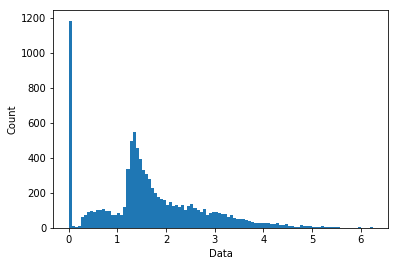

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.hist(scored[:, 1], density=False, bins=100) 
plt.ylabel('Count')
plt.xlabel('Data')
plt.show()

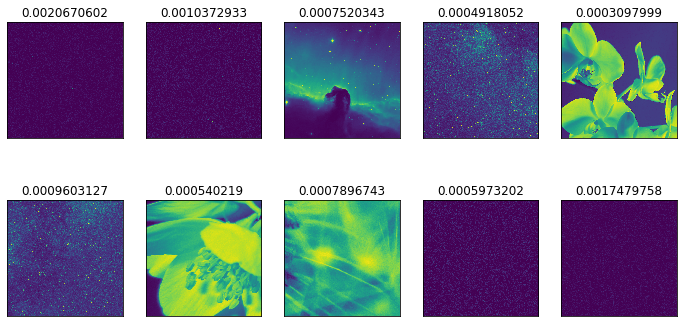

In [3]:
def plot_images(imgs):
    fig = plt.figure(figsize=[12, 6])
    
    for i in range(10):
        (img_name, img_score) = imgs[i]
        
        a = fig.add_subplot(2, 5, i+1)
        img_path = os.path.join(root, 'scored', str(int(img_name)) + '.png')
        img = mpimg.imread(img_path)
        img_plt = plt.imshow(img)
        img_plt.axes.get_xaxis().set_visible(False)
        img_plt.axes.get_yaxis().set_visible(False)
        a.set_title(str(img_score))
    

low = scored[scored[:, 1] < 0.1]
low = low[:10]
plot_images(low)

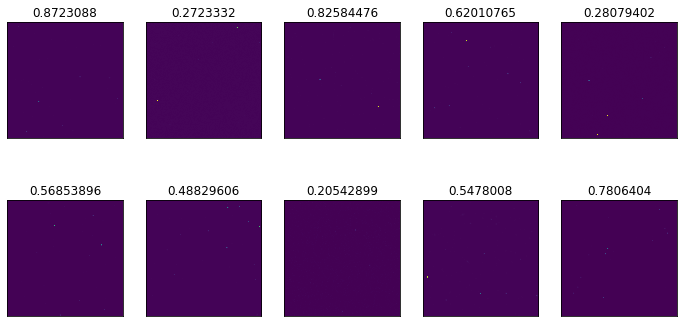

In [4]:
med = scored[(scored[:, 1] > 0.1) & (scored[:, 1] < 1)]
med = med[:10]
plot_images(med)

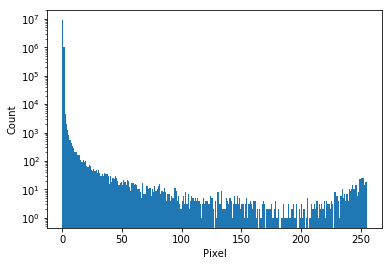

In [5]:
hig = scored[(scored[:, 1] > 5.5)]

def _load_imgs(names, scored=True):
    for name in names:
        folder = 'scored' if scored else 'labeled'
        img_path = os.path.join(root, folder, str(int(name)) + '.png')
        yield (mpimg.imread(img_path)  * 255).astype(np.uint8)


names = hig[:, 0]
imgs = list(_load_imgs(names))
pixels = np.stack(imgs).reshape([-1])

plt.hist(pixels, density=False, bins=255) 
plt.ylabel('Count')
plt.xlabel('Pixel')
plt.yscale('log')
plt.show()

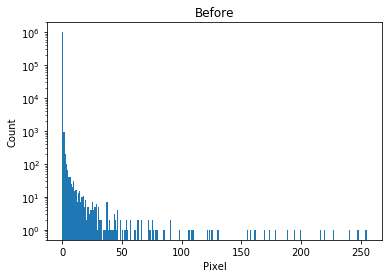

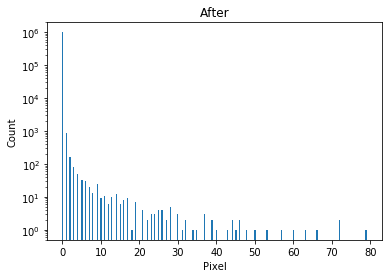

In [24]:
img = imgs[0]

def _hist(img, title, line=None):
    plt.hist(img.reshape([-1]), density=False, bins=255) 
    if line is not None:
        plt.plot(line[:,0], line[:, 1], 'r-')
    plt.ylabel('Count')
    plt.xlabel('Pixel')
    plt.yscale('log')
    plt.title(title)
    plt.show()
    
_hist(img, 'Before')

# mask stars
idx = np.where(img > 230)
r = 20
masked_img = np.array(img, copy=True)
for (i, j) in zip(*idx):
    top = max(i-r, 0)
    bottom = min(i+r, 1000)
    left = max(j-r, 0)
    right = min(j+r, 1000)
    
    masked_img[top:bottom, left:right] = 0
    
_hist(masked_img, 'After')

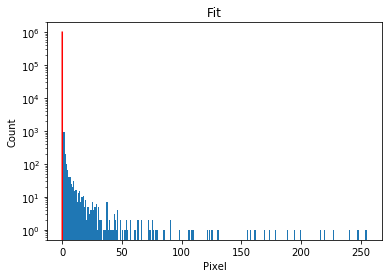

In [70]:
from scipy import optimize as opt
from scipy.stats import wasserstein_distance as wd
    
img = np.reshape(imgs[0], [-1])
xs = np.linspace(0, 255, 256)
ys = np.asarray([np.count_nonzero(img == x) for x in xs])

def normal(x, si, mu):
    t = (x - mu)/si
    return 1/(si * np.sqrt(2*np.pi))*np.exp(-0.5 * t*t)

popt, pcov = opt.curve_fit(normal, xs, ys)

line = np.stack([xs, normal(xs, *popt)], axis=-1)
_hist(img, 'Fit', line)

In [8]:
real = labeled[(labeled[:, 1] == 1)]
names = real[:, 0]
imgs = list(_load_imgs(names, scored=False))

In [79]:
# mask stars
r = 30
mimgs = []
for img in imgs:
    idx = np.where(img > 150)
    masked_img = np.array(img, copy=True, dtype=np.int32)
    for (i, j) in zip(*idx):
        top = max(i-r, 0)
        bottom = min(i+r, 1000)
        left = max(j-r, 0)
        right = min(j+r, 1000)

        masked_img[top:bottom, left:right] = -1
        assert(masked_img[i,j] == -1)
        
    mimgs.append(masked_img)

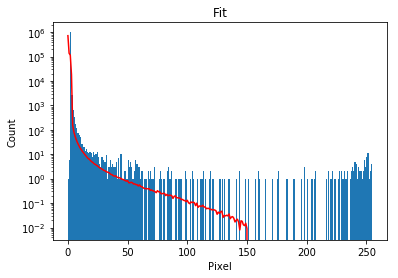

In [80]:
ps = np.stack(mimgs).reshape([-1])

xs = np.linspace(0, 255, 256)
ys = np.asarray([np.count_nonzero(ps == x) for x in xs])
ys = ys/len(imgs)

line = np.stack([xs, ys], axis=-1)
_hist(img, 'Fit', line)

In [81]:
print(np.amin(ps), np.amax(ps))

-1 150


0.0 149.0


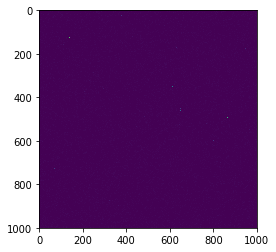

In [82]:
from scipy import stats

pk = ys/np.sum(ys)
bg_rv = stats.rv_discrete(name='bg', values=(xs, pk))

bg = np.random.uniform(size=(1000, 1000))
bg = bg_rv.ppf(bg)

print(np.amin(bg), np.amax(bg))

imgplot = plt.imshow(bg)
plt.show()